### Retrieve Image

In [1]:
import os
from langchain_core.documents import Document
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from langchain.schema import BaseRetriever
from typing import List
import oracledb
import pandas as pd
import base64
from IPython.display import Image, display
from dotenv import find_dotenv, load_dotenv

from langchain_community.embeddings import OCIGenAIEmbeddings
from langchain_community.chat_models import ChatOCIGenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, SystemMessage

_ = load_dotenv(find_dotenv())
oracledb.init_oracle_client()

UN = os.getenv("UN")
PW = os.getenv("PW")
DSN = os.getenv("DSN")
OCI_COMPARTMENT_ID = os.getenv("OCI_COMPARTMENT_ID")

### Utils

In [ ]:
def get_embedding(text: str) -> list:
  embeddings = OCIGenAIEmbeddings(
    model_id="cohere.embed-multilingual-v3.0",
    service_endpoint="https://inference.generativeai.us-chicago-1.oci.oraclecloud.com",
    compartment_id=OCI_COMPARTMENT_ID,
  )
  return embeddings.embed_query(text)

In [3]:
def chat_with_image(image_path: str, prompt: str, system_prompt: str = None) -> str:
  with open( image_path, "rb") as img_file:
    image_data = base64.b64encode(img_file.read()).decode("utf-8")
  
  prompt_with_image = [
    SystemMessage(
        content=system_prompt
    ),
    HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {
              "type": "image_url",
              "image_url": {
                "url": "data:image/png;base64,"+image_data,
            }
        },
        ]
      )
  ]

  llm = ChatOCIGenAI(
      model_id="meta.llama-4-scout-17b-16e-instruct",
      service_endpoint="https://inference.generativeai.us-chicago-1.oci.oraclecloud.com",
      compartment_id=OCI_COMPARTMENT_ID,
      )
  result = llm.invoke(prompt_with_image)
  # print(f"Result: {result}") 
  return result.content

In [4]:
def summarize_image_to_text(image_path: str) -> str:
  with open(image_path, "rb") as img_file:
    image_data = base64.b64encode(img_file.read()).decode("utf-8")

  prompt = {
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": "Summarize the following this image. Answer in English.",
        },
        {
            "type": "image_url",
            "image_url": {
              "url": "data:image/png;base64,"+image_data,
            }
        },
    ],
  }
  llm = ChatOCIGenAI(
    model_id="meta.llama-4-scout-17b-16e-instruct",
    service_endpoint="https://inference.generativeai.us-chicago-1.oci.oraclecloud.com",
    compartment_id=OCI_COMPARTMENT_ID,
    )
  try:
      result = llm.invoke([prompt])
      print(f"Image Summary: {result}")
      return result.content
  except Exception as e:
      print(f"Error in image summarization: {e}")
      return None

In [5]:
def save_image_content(file_name: str, file_path: str, summary: str, embedding: list):
  sql = """
        INSERT INTO embedding_contents (name, summary, embedding, file_path, content_type, image_blob)
        VALUES (:name, :summary, :embedding, :file_path, :content_type, empty_blob())
        returning image_blob into :blobdata
      """
  
  try:
    with oracledb.connect(user=UN, password=PW, dsn=DSN) as conn:
      with conn.cursor() as cursor:
        blobdata = cursor.var(oracledb.DB_TYPE_BLOB)
        params = {
            'name': file_name,
            'summary': summary,
            'embedding': str(embedding),
            'file_path': file_path,
            'content_type': "image",
            'blobdata': blobdata
        }
        cursor.execute(sql, params)
        blob, = blobdata.getvalue()
        offset = 1
        bufsize = 65536
        with open(file_path, 'rb') as f:
            while True:
                data = f.read(bufsize)
                if data:
                    blob.write(data, offset)
                if len(data) < bufsize:
                    break
                offset += bufsize
        
        print(f"Success insert {file_name} into image_contents")
      conn.commit()
  except oracledb.DatabaseError as e:
    error, = e.args
    print(f"Error at save_content")
    print(f"Oracle error code: {error.code}")
    print(f"Oracle error message: {error.message}")
  except Exception as e:
    print(f"Error:save_image_content: {e}")
    return None



In [6]:
def summarize_and_embedding_image(file_path):
  with open(file_path, "rb") as img_file:
    image_lob = img_file.read()
    print(f"type: {type(image_lob)}")
  
  print(f"file_path: {file_path}")
  image_summary = summarize_image_to_text(file_path)
  print(f"Image Summary: {image_summary}")
  image_embedding = get_embedding(image_summary)
  
  file_name = os.path.basename(file_path)
  save_image_content(
    file_name=file_name,
    file_path=file_path,
    summary=image_summary,
    embedding=image_embedding
  )
  return {"summary": image_summary}

### Insert image embedding

In [7]:
summarize_and_embedding_image(file_path="../../images/net_income.png")
summarize_and_embedding_image(file_path="../../images/revenue.png")

type: <class 'bytes'>
file_path: ../../images/net_income.png
Image Summary: content="The image presents a bar graph illustrating the net income for the past five years, from FY20 to FY24. The graph features red bars representing each fiscal year's net income, with the corresponding values displayed above each bar.\n\nHere is a detailed breakdown of the information presented in the graph:\n\n*   **FY20**\n    *   Net Income: 47,686\n*   **FY21**\n    *   Net Income: 49,175\n*   **FY22**\n    *   Net Income: 51,182\n*   **FY23**\n    *   Net Income: 52,009\n*   **FY24**\n    *   Net Income: 55,603\n\nThe graph shows a steady increase in net income over the five-year period, with the highest net income recorded in FY24. The y-axis represents the net income in increments of 10,000, ranging from 0 to 60,000.\n\nIn summary, the graph provides a clear visual representation of the company's net income growth over the past five years, with a notable increase from FY20 to FY24." additional_kwarg

{'summary': "The image presents a bar graph illustrating the revenue for the past five years, from FY20 to FY24. The graph features red bars representing each year's revenue, with numerical values displayed above each bar.\n\nHere is a detailed breakdown of the revenue for each year:\n\n*   **FY20:** 211,357\n*   **FY21:** 208,523\n*   **FY22:** 214,691\n*   **FY23:** 226,914\n*   **FY24:** 244,542\n\nThe graph's y-axis is labeled with increments of 50,000, ranging from 0 to 250,000, providing a clear scale for measuring the revenue. The x-axis lists the fiscal years, allowing for easy comparison between the different periods.\n\nOverall, the graph effectively conveys the revenue trends over the past five years, with a notable increase in revenue from FY20 to FY24."}

### Retriever

In [8]:
class CustomEmbeddingRetriever(BaseRetriever):
    """
    Custom image retriever.
    """

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        docs: List[Document] = []
        embed_query = str(get_embedding(query))
        try:
            with oracledb.connect(user=UN, password=PW, dsn=DSN) as connection:
                with connection.cursor() as cursor:
                    cursor.setinputsizes(oracledb.DB_TYPE_VECTOR)
                    select_sql = f"""
                        SELECT
                            id,
                            name,
                            content_type,
                            file_path,
                            summary
                        FROM
                            embedding_contents
                        ORDER BY VECTOR_DISTANCE(embedding, to_vector(:1, 1024, FLOAT32), COSINE)
                        FETCH FIRST 3 ROWS ONLY
                    """
                    cursor.execute(select_sql, [embed_query])
                    index = 1
                    for row in cursor:
                        doc = Document(
                            page_content=row[3],
                            metadata={
                                'id':row[0],
                                'name': row[1],
                                'content_type': row[2],
                                'file_path': row[3],
                                'vector_index': index
                                }
                            )
                        docs.append(doc)
                        index += 1
                connection.close()
                        
        except oracledb.DatabaseError as e:
            print(f"Database error: {e}")
            raise
        except Exception as e:
            print("Error Vector Search:", e)
        
        return docs

### Retrieve Image & Answer

In [9]:
def get_text_by_image(query: str):
    """
    Text to Image
    """

    retriever = CustomEmbeddingRetriever()
    result_images = retriever.invoke(query)
    
    id = result_images[0].metadata['id']
    file_name = os.path.basename(result_images[0].metadata['file_path'])
    print(f"file_name: {file_name}")
    try:
        with oracledb.connect(user=UN, password=PW, dsn=DSN) as connection:
            with connection.cursor() as cursor:
                cursor.setinputsizes(oracledb.DB_TYPE_VECTOR)
                select_sql = f"""
                    SELECT
                        image_blob
                    FROM
                        embedding_contents
                    WHERE id = :1
                """
                cursor.execute(select_sql, [id])
                blob, = cursor.fetchone()
                offset = 1
                bufsize = 65536

                with open("../images/" + file_name, 'wb') as f:
                    while True:
                        data = blob.read(offset, bufsize)
                        if data:
                            f.write(data)
                        if len(data) < bufsize:
                            break
                        offset += bufsize
            connection.close()
                    
    except oracledb.DatabaseError as e:
        print(f"Database error: {e}")
        raise
    except Exception as e:
        print("Error Vector Search:", e)
    
    return result_images[0]

In [10]:
def get_text_with_image(question: str):
    
    prompt = ChatPromptTemplate([
        ("system", "あなたは言語翻訳のAIアシスタントです。日本語を英語に翻訳してください。"),
        ("human", "{input} "),
    ])
    
    llm = ChatOCIGenAI(
        model_id="cohere.command-a-03-2025",
        service_endpoint="https://inference.generativeai.us-chicago-1.oci.oraclecloud.com",
        compartment_id=OCI_COMPARTMENT_ID,
    )
    chain = {'input': RunnablePassthrough()} | prompt | llm | StrOutputParser()
    question_en = chain.invoke({"input":question})
    
    result_images = get_text_by_image(question_en)
    # print(result_images)
    image_path = "../images/" + os.path.basename(result_images.metadata['file_path'])
    res = chat_with_image(
        image_path=image_path,
        prompt=question_en,
        system_prompt=(
            "You are a AI assistant. Please answer the question based on the image.\n"

            "** Question **"
            f"{question}"

            "** Output **\n"
            "- FYXX: 1234\n"
            "- FYXX: 5678\n"
        )
    )
    return res
    

file_name: revenue.png
The sales trend over the past 5 years is as follows:

- **FY20**: 211,357
- **FY21**: 208,523 (a decrease from FY20)
- **FY22**: 214,691 (an increase from FY21)
- **FY23**: 226,914 (an increase from FY22)
- **FY24**: 244,542 (an increase from FY23)

Overall, the sales trend shows a slight decrease in FY21, but a steady increase in the subsequent years, with the highest revenue recorded in FY24.
Displaying image to check Answer: revenure.png


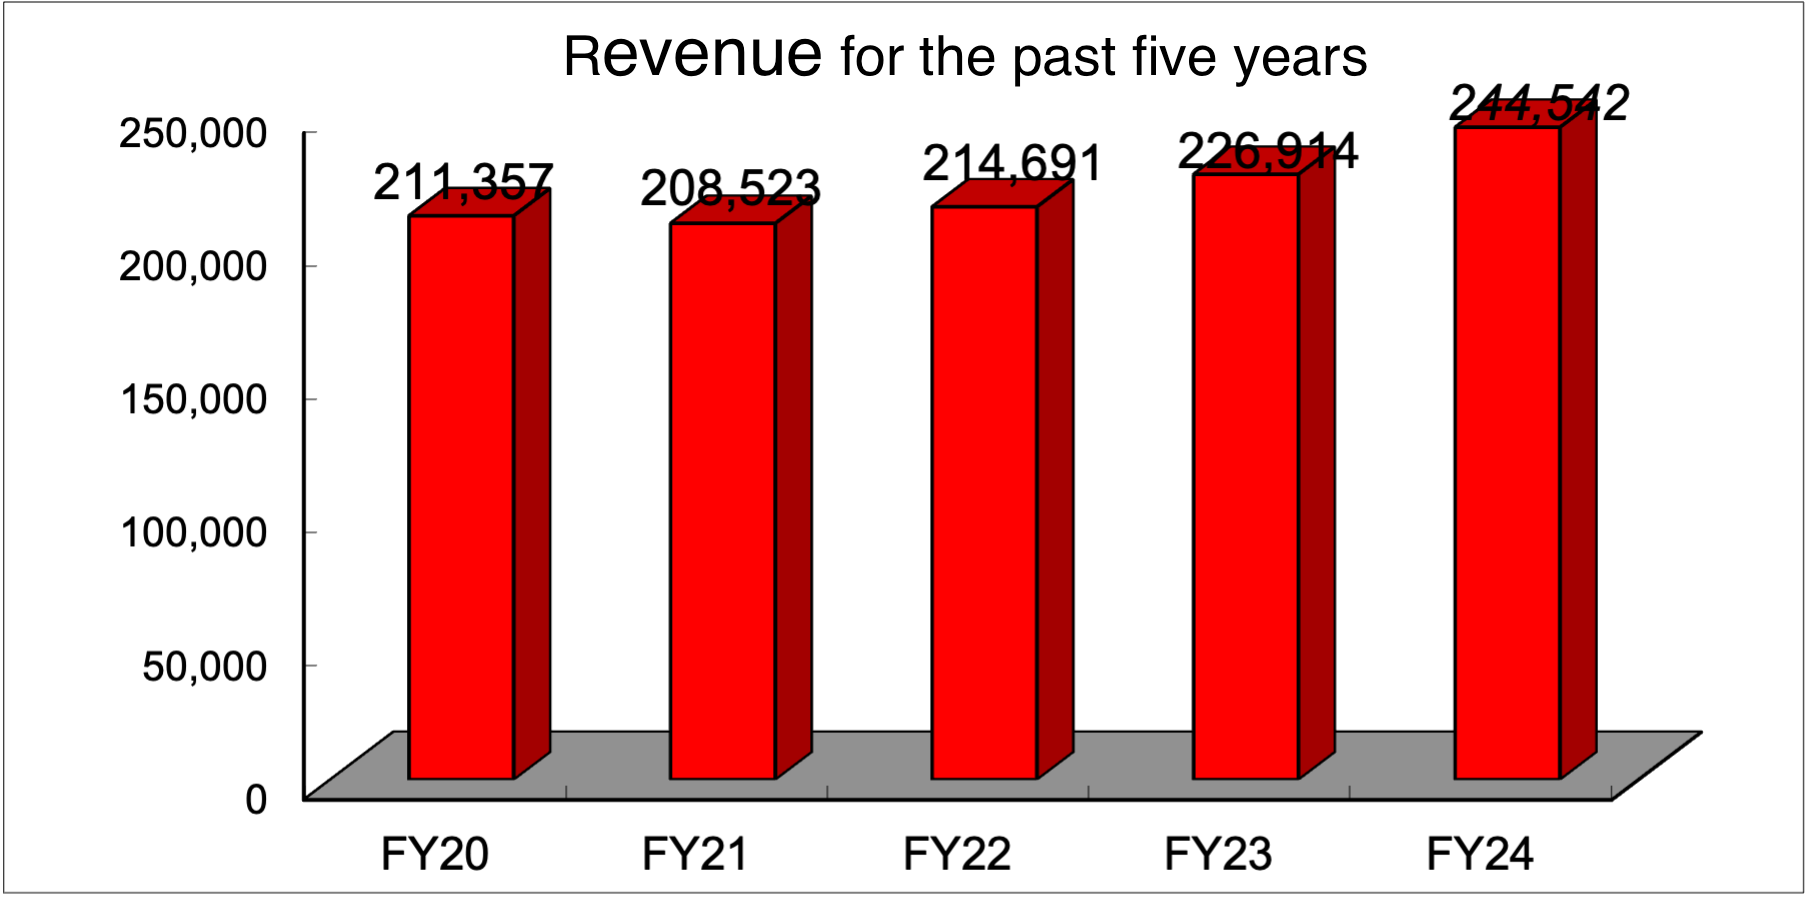

In [11]:
query = "5年間の売り上げの推移を教えてください。"
result = get_text_with_image(query)
print(result)
image_path = f"../images/revenue.png"
print(f"Displaying image to check Answer: revenure.png")
display(Image(filename=image_path, width=1000, height=1000))